# цель — проверить, есть ли сигнал без шума внутри зашумленного сигнала

# Этап 1: Подготовка и классификация данных

Первый этап этого проекта включает использование набора данных __logged_data.csv__, полученного с платформы Kaggle (https://www.kaggle.com/datasets/suraj520/rf-signal-data). Цель состоит в подготовке данных и применении четко определенных критериев для классификации сигналов как чистых или шумных.

Для этого:

1. Данные анализируются и очищаются от несоответствий.

2. Устанавливаются правила классификации для определения характеристик, отличающих чистые сигналы от шумных.

3. Классифицированные сигналы сохраняются в поднаборе данных под названием classification_dataset.csv.

# 1. Импорт необходимых библиотек

__pandas__ используется для обработки и анализа табличных данных.

__numpy__ обеспечивает поддержку работы с массивами и векторами, необходимых для обработки сигналов.

__scipy.signal__ содержит инструменты для обработки сигналов, включая фильтрацию.

__sklearn.model_selection__ импортируется, но не используется в коде; обычно применяется для разбиения данных на обучающие и тестовые выборки.

In [4]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from sklearn.model_selection import train_test_split


# 2. Загрузка и предобработка данных

Загружается CSV-файл в объект DataFrame.

Поле __Timestamp__ преобразуется в формат даты и времени для удобства работы.

Удаляется столбец __Air Pressure__ (если он есть), поскольку он не используется.

Пропущенные значения в __Interference Type__ заменяются на "None", а строки без __I/Q__ Data удаляются.

In [7]:
def load_and_preprocess(filename):
    df = pd.read_csv(filename)  # Чтение CSV-файла
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Преобразование временных меток
    df = df.drop(columns=['Air Pressure'], errors='ignore').fillna({'Interference Type': "None"})  # Удаление ненужного столбца и обработка пропусков
    df = df.dropna(subset=['I/Q Data'])  # Удаление записей с отсутствующими значениями I/Q
    return df

# 3. Нормализация комплексных данных I/Q

__eval(iq_str)__ преобразует строку в массив комплексных чисел.

__np.real(iq_array)__ выделяет вещественную часть сигнала.

Нормализация происходит путем деления на максимальное абсолютное значение, что позволяет стандартизировать амплитуду сигнала.

In [10]:
def normalize_iq(iq_str):
    iq_array = np.array(eval(iq_str))  # Преобразование строки в массив
    iq_real = np.real(iq_array)  # Извлечение действительной части
    return iq_real / np.max(np.abs(iq_real))  # Нормализация к диапазону [-1,1]

# 4. Фильтрация сигнала (Фильтр нижних частот)

Используется цифровой __фильтр Баттерворта__ (signal.butter) 6-го порядка.

__cutoff=0.05__ — нормализованная частота среза.

__signal.filtfilt__ применяет фильтр без фазового сдвига, обеспечивая плавную обработку сигнала.

In [13]:
def lowpass_filter(signal_data, cutoff=0.05, order=6):
    b, a = signal.butter(order, cutoff, btype='low', analog=False)  # Создание параметров фильтра Баттерворта
    return signal.filtfilt(b, a, signal_data)  # Применение фильтра к сигналу

# 5. Обработка сигналов

In [15]:
def process_signals(df):
    df['I/Q Data'] = df['I/Q Data'].apply(normalize_iq)  # Нормализация всех сигналов
    
    signal_strength_clean = -60  # Пороговое значение для чистого сигнала
    signal_strength_noise = -70  # Пороговое значение для зашумленного сигнала
    
    clean_signals = df[(df['Signal Strength'] >= signal_strength_clean) & 
                      (df['Interference Type'] == "None")].copy()  # Выборка чистых сигналов
    noise_signals = df[(df['Signal Strength'] <= signal_strength_noise) | 
                    (df['Interference Type'] != "None")].copy()  # Выборка зашумленных сигналов
    
    clean_signals['processed_signal'] = clean_signals['I/Q Data'].apply(lowpass_filter)  # Фильтрация чистых сигналов
    noise_signals['processed_signal'] = noise_signals['I/Q Data']  # Шум не фильтруется
    
    return clean_signals, noise_signals


# 6. Создание датасета для классификации

Выбирается одинаковое число чистых и шумных сигналов (min_samples).

Создаются два набора:

__class = 1__ — чистые сигналы.

__class = 0__ — шумные сигналы.

Данные сохраняются в формате CSV для дальнейшего использования в моделях машинного обучения.

In [18]:
def create_classification_dataset(clean_signals, noise_signals, output_filename="classification_dataset.csv"):
    min_samples = min(len(clean_signals), len(noise_signals))  # Балансировка классов
    clean_samples = clean_signals.sample(min_samples, random_state=42)
    noise_samples = noise_signals.sample(min_samples, random_state=42)
    
    clean_data = {
        'signal': clean_samples['processed_signal'].tolist(),
        'class': 1,
        'signal_strength': clean_samples['Signal Strength'].values,
        'interference_type': 'None'
    }
    
    noise_data = {
        'signal': noise_samples['processed_signal'].tolist(),
        'class': 0,
        'signal_strength': noise_samples['Signal Strength'].values,
        'interference_type': noise_samples['Interference Type'].values
    }
    
    df_clean = pd.DataFrame(clean_data)
    df_noise = pd.DataFrame(noise_data)
    df_final = pd.concat([df_clean, df_noise], ignore_index=True)
    
    df_final.to_csv(output_filename, index=False)
    print(f"Датасет сохранен в {output_filename} ({len(df_clean)} чистых, {len(df_noise)} зашумленных)")
    
    return df_final


# 7. Создание подмножества данных

Создается новый набор данных с парами __чистых__ и __зашумленных сигналов__.

Сигналы сохраняются в classification_dataset.csv1 для дальнейшего анализа

In [20]:
def create_subdataset_from_classification(classification_df, output_filename="classification_dataset.csv1"):
    num_samples = min(len(classification_df[classification_df['class'] == 1]),
                      len(classification_df[classification_df['class'] == 0]))
    
    clean_samples = classification_df[classification_df['class'] == 1].sample(num_samples, random_state=42)
    noise_samples = classification_df[classification_df['class'] == 0].sample(num_samples, random_state=42)
    
    subdataset_data = {
        'clean_signal': clean_samples['signal'].tolist(),
        'noise_signal': noise_samples['signal'].tolist(),
        'class': 1,
        'clean_signal_strength': clean_samples['signal_strength'].values,
        'noise_signal_strength': noise_samples['signal_strength'].values,
        'clean_interference_type': 'None',
        'noise_interference_type': noise_samples['interference_type'].values
    }
    
    subdataset_df = pd.DataFrame(subdataset_data)
    subdataset_df.to_csv(output_filename, index=False)
    print(f"Подмножество данных сохранено в {output_filename} ({len(subdataset_df)} записей).")
    
    return subdataset_df


# 8. Главный pipeline

Выполняется вся обработка данных.

__Запускается__ процесс нормализации, фильтрации и сохранения обработанных сигналов.

__Основное назначение__ — автоматизированный анализ и подготовка данных для последующего обучения нейросетей или классификационных алгоритмов.

In [23]:
def main():
    df = load_and_preprocess("logged_data.csv")
    clean_signals, noise_signals = process_signals(df)
    classification_df = create_classification_dataset(clean_signals, noise_signals)
    create_subdataset_from_classification(classification_df)

if __name__ == "__main__":
    main()

Датасет сохранен в classification_dataset.csv (16701 чистых, 16701 зашумленных)
Подмножество данных сохранено в classification_dataset.csv1 (16701 записей).


# Этап 2: Импорт и присвоение меток данных

На втором этапе проекта выполняется импорт ранее созданного поднабора данных, сохранённого в файле __classification_dataset.csv__. Этот файл содержит сигналы, классифицированные как __чистые__ или __шумные__.

Основные действия на этом этапе:

- Разделение сигналов: Подтверждение разделения сигналов на две основные категории: чистые и шумные.

- Присвоение меток: Назначение числовых меток категориям сигналов:

__Чистые__ сигналы обозначаются как 1.

__Шумные__ сигналы обозначаются как 0.

# 1. Импорт необходимых библиотек
ast: позволяет безопасно преобразовывать строковые представления списков в объекты Python.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# 2. Загрузка датасета

Используется __try-except__ для обработки возможного отсутствия файла.

Если файл не найден, программа выдает исключение с пояснением.

In [28]:
try:
    df = pd.read_csv("classification_dataset.csv")
except FileNotFoundError:
    raise FileNotFoundError("Файл «classification_dataset.csv» не найден. Проверьте путь.")


In [29]:
df

,signal,class,signal_strength,interference_type
0,[-0.33213146 -0.30968252 -0.28811094 -0.267443...,1,-12,NaN
1,[-9.62577621e-01 -8.43205546e-01 -7.23591030e-...,1,-32,NaN
2,[ 0.56690547 0.50536125 0.44577895 0.388544...,1,-10,NaN
3,[ 0.39386227 0.31781643 0.24474637 0.175228...,1,-52,NaN
4,[-0.20261762 -0.17645794 -0.14961994 -0.122629...,1,-56,NaN
...,...,...,...,...
33397,[ 6.62979306e-01 6.90139102e-01 -3.73090152e-...,0,-92,Intermodulation
33398,[-0.33943863 -0.3544555 -0.72930125 -0.288341...,0,-21,Intermodulation
33399,[-0.13628891 0.68867697 -0.46414623 0.649338...,0,-62,Co-channel
33400,[ 0.10386065 0.01921679 0.91070051 -0.220288...,0,-5,Co-channel


# 3. Преобразование сигналов из строкового формата в массивы

__ast.literal_eval(signal_str)__: безопасный способ преобразования строки в список.

Если __literal_eval__ не удается, строка очищается от лишних символов ([], \n).

Значения разбиваются на элементы и преобразуются в __float__, создавая массив NumPy.

In [31]:
def convert_signal(signal_str):
    if isinstance(signal_str, str):
        try:
            return np.array(ast.literal_eval(signal_str))  # Преобразование строки в массив
        except:
            cleaned = signal_str.strip('[]').replace('\n', ' ').split()  # Очистка строки от символов []
            return np.array([float(x) for x in cleaned])  # Преобразование в массив чисел
    return signal_str

df['signal'] = df['signal'].apply(convert_signal)

# 4. Настройка стиля графиков

In [33]:
try:
    plt.style.use('seaborn-v0_8')  # Современный стиль
except:
    plt.style.use('ggplot')  # Альтернативный стиль

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10


# 5. Создание фигуры с подграфиками
__plt.subplots(2, 3)__: создает сетку из 6 подграфиков (2 ряда, 3 колонки).

__figsize=(18, 10)__: задает размер фигуры в дюймах (ширина x высота).

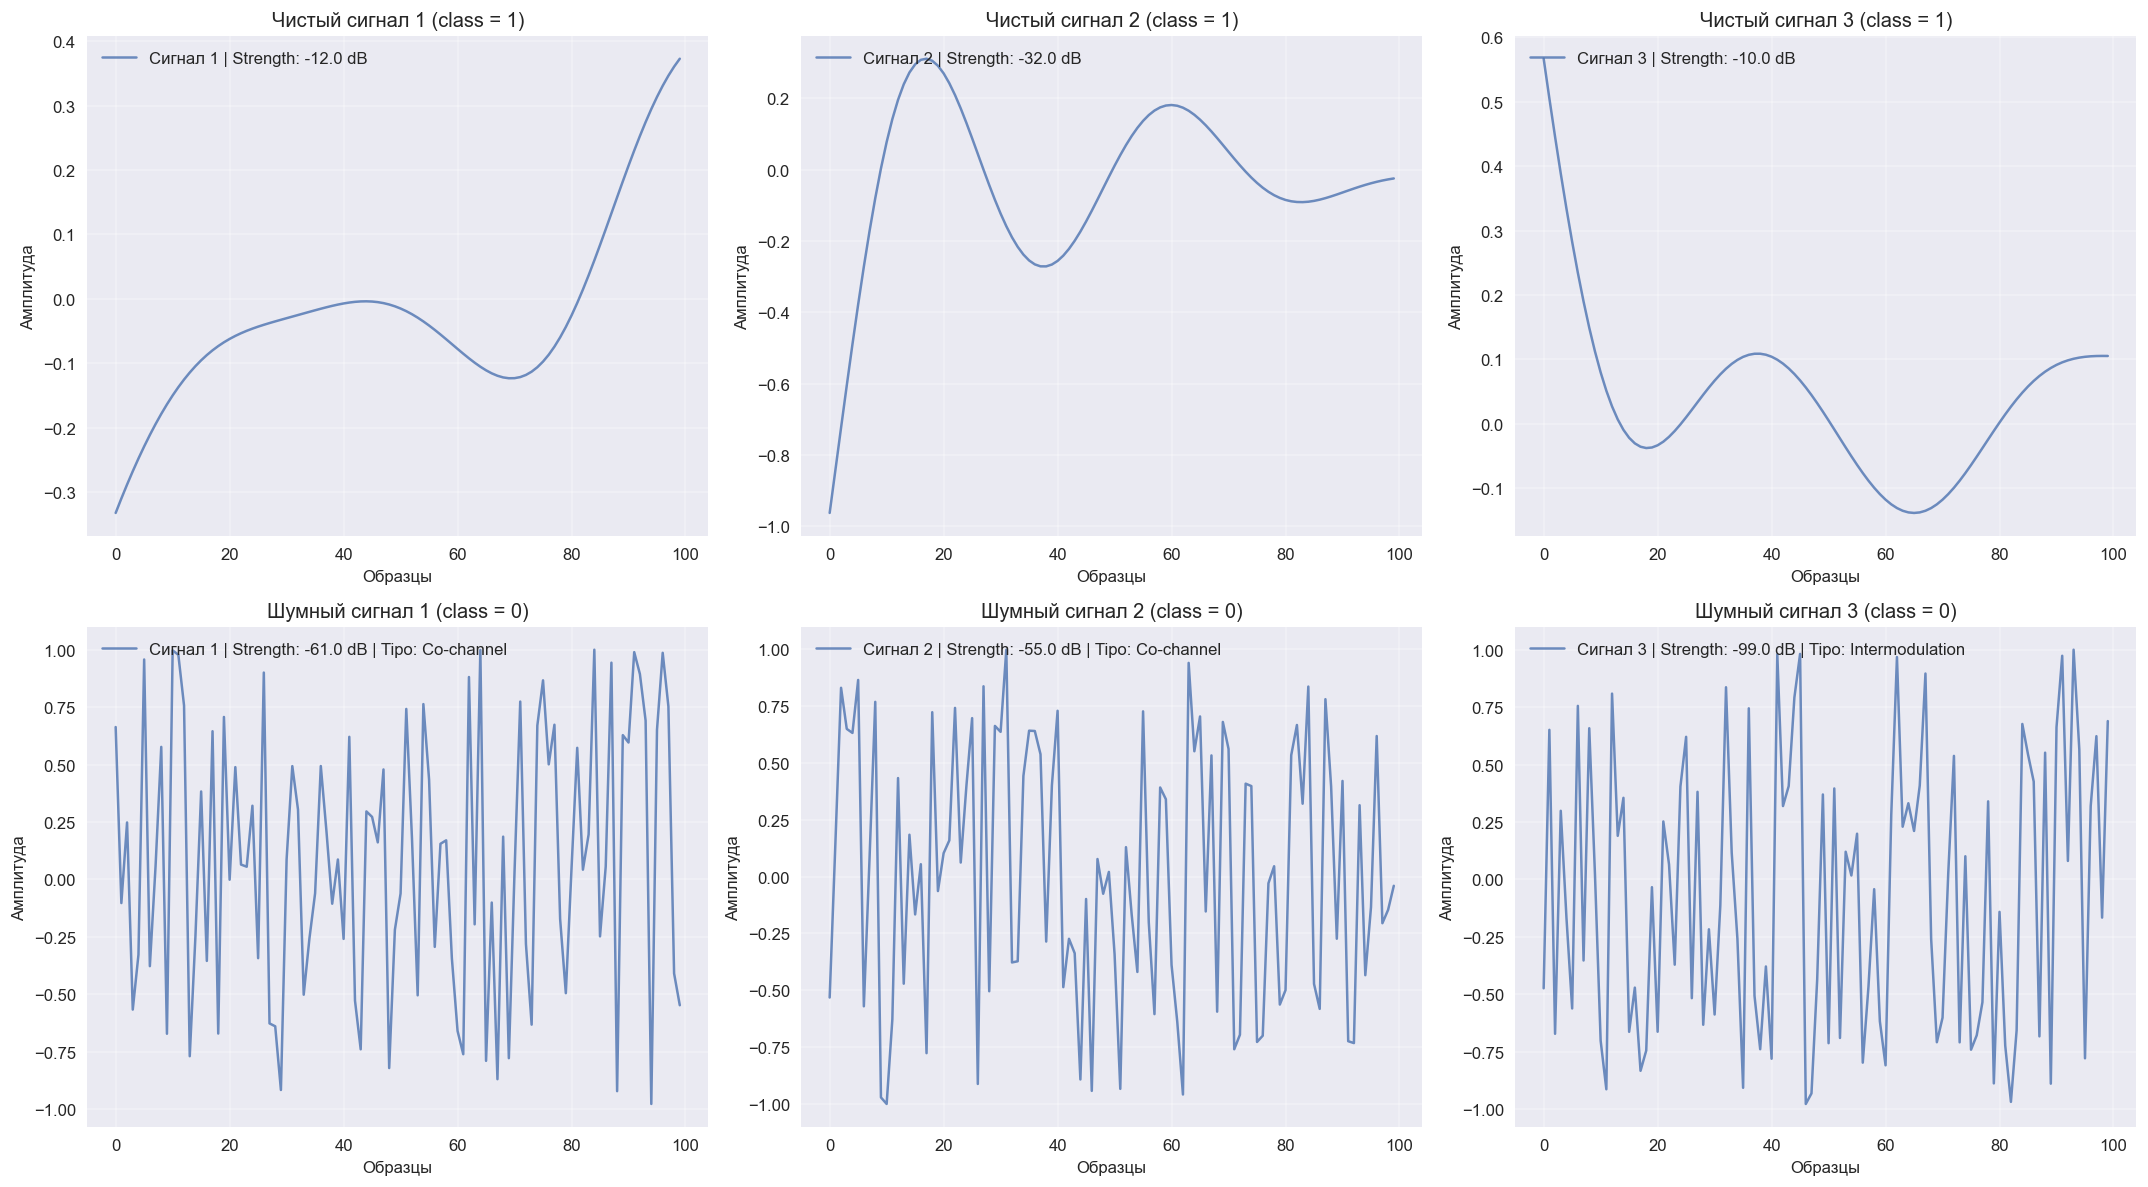

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 строки, 3 столбца
clean_signals = df[df['class'] == 1]
if not clean_signals.empty:
    for i in range(min(3, len(clean_signals))):
        signal = clean_signals.iloc[i]['signal']
        strength = clean_signals.iloc[i]['signal_strength']
        
        ax = axes[0, i]  # Доступ к соответствующему подграфику
        ax.plot(signal[:200], label=f"Сигнал {i+1} | Strength: {strength:.1f} dB", alpha=0.8, linewidth=1.5)
        ax.set_title(f'Чистый сигнал {i+1} (class = 1)', fontsize=12)
        ax.set_xlabel('Образцы', fontsize=10)
        ax.set_ylabel('Амплитуда', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
noisy_signals = df[df['class'] == 0]
if not noisy_signals.empty:
    for i in range(min(3, len(noisy_signals))):
        signal = noisy_signals.iloc[i]['signal']
        strength = noisy_signals.iloc[i]['signal_strength']
        interference = noisy_signals.iloc[i]['interference_type']
        
        ax = axes[1, i]  # Доступ к подграфику на второй строке
        ax.plot(signal[:200], label=f"Сигнал {i+1} | Strength: {strength:.1f} dB | Tipo: {interference}", alpha=0.8, linewidth=1.5)
        ax.set_title(f'Шумный сигнал {i+1} (class = 0)', fontsize=12)
        ax.set_xlabel('Образцы', fontsize=10)
        ax.set_ylabel('Амплитуда', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')
plt.tight_layout()  # Оптимизация размещения элементов
plt.savefig('sinais_comparados.png', bbox_inches='tight')  # Сохранение изображения
plt.show()  # Отображение графиков

# 6. Подмножество данных, полученных из файла classification_dataset.csv и представленных как classification_dataset.csv1, все отмечены как класс 1

In [37]:
df = pd.read_csv("classification_dataset.csv1")
df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.06753569 0.06815317 0.06744601 0.065591...,[-0.51403025 0.07929418 -1. 0.282124...,1,-7,-87,NaN,Co-channel
1,[ 0.19205764 0.17679055 0.16082618 0.144290...,[ 0.70620408 -0.18568454 0.06479348 -0.641807...,1,-42,-39,NaN,Intermodulation
2,[ 6.11258258e-01 5.52137776e-01 4.92440591e-...,[ 0.62373061 -0.16386374 0.79554744 0.913140...,1,-18,-66,NaN,Co-channel
3,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,[ 0.13570954 -0.06391973 0.29180463 0.637100...,1,-3,-29,NaN,Co-channel
4,[-2.83198484e-01 -2.52492646e-01 -2.22086926e-...,[ 1.67946804e-01 -2.21649870e-01 -2.38364748e-...,1,-9,-49,NaN,Co-channel
...,...,...,...,...,...,...,...
16696,[ 0.33583505 0.30042465 0.2668221 0.235250...,[-0.08967906 -0.76337204 -0.22428849 0.075496...,1,-30,-90,NaN,NaN
16697,[ 0.35694581 0.30739893 0.25751277 0.207717...,[-0.02974317 -0.94572458 0.67620933 -0.383027...,1,-40,-61,NaN,Co-channel
16698,[-9.16795722e-01 -8.38317861e-01 -7.60477905e-...,[ 0.46575862 -0.87626119 -0.96593695 0.493635...,1,-46,-81,NaN,Adjacent-channel
16699,[ 0.30016228 0.30411639 0.30551647 0.304368...,[ 0.6037686 -0.50345037 -0.08180763 0.559866...,1,-42,-28,NaN,Adjacent-channel


# 7. Матрица корреляции между чистыми сигналами

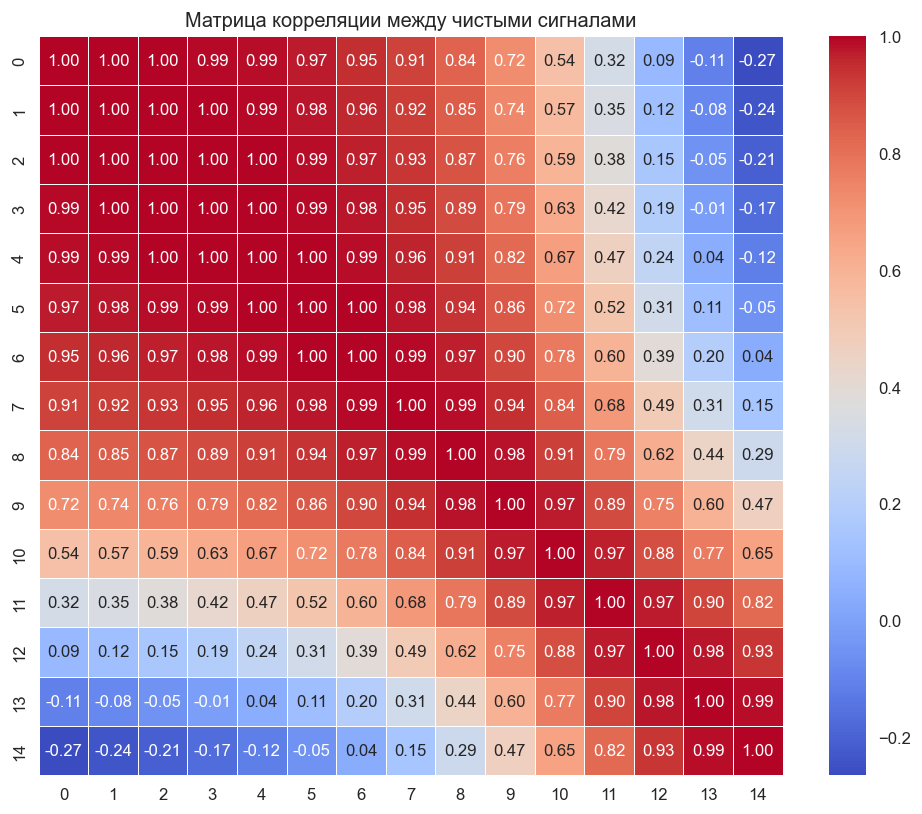

In [39]:
import seaborn as sns

# Функция для очистки строки и преобразования её в числовой массив
def clean_signal_to_array(signal_str):
    # Удаление лишних пробелов и нежелательных символов
    signal_str = signal_str.strip()  # Удаление начальных и конечных пробелов
    signal_str = signal_str.replace('[', '').replace(']', '')  # Удаление квадратных скобок
    signal_list = np.array([float(x) for x in signal_str.split()])  # Преобразование в массив чисел
    return signal_list

# Загрузка классификационного датасета
classification_df = pd.read_csv("classification_dataset.csv1")

# Преобразование сигналов из строкового формата в числовые массивы
clean_signals = np.array([clean_signal_to_array(signal) for signal in classification_df['clean_signal']])

# Ограничение матрицы первыми 15 переменными
clean_signals_subset = clean_signals[:, :15]

# Вычисление корреляционной матрицы для первых 20 сигналов
correlation_matrix = np.corrcoef(clean_signals_subset, rowvar=False)

# Построение тепловой карты корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции между чистыми сигналами')
plt.show()


# 8. Исключение сигналов, не удовлетворяющих минимальной корреляции, и отнесение их к классу 0
На этом шаге мы рассмотрим матрицу корреляции между чистыми сигналами и исключим пары сигналов, которые не удовлетворяют минимальному набору корреляций

In [41]:
import pandas as pd
import numpy as np

# Функция для преобразования массива в строку формата "[v1 v2 v3 ...]"
def array_to_str(arr):
    return "[" + " ".join(map(str, arr)) + "]"

# Функция для обработки строковых представлений сигналов и преобразования их в массивы NumPy
def clean_signal_to_array(signal_str):
    signal_str = signal_str.strip().replace('[', '').replace(']', '')  # Удаление лишних символов
    return np.array([float(x) for x in signal_str.split()])  # Преобразование в массив чисел

# Загрузка исходного набора данных
df = pd.read_csv("classification_dataset.csv1")

# Ограничение числа образцов (для оптимизации производительности)
N = 50 if len(df) > 50 else len(df)
df = df.head(N).copy()

# Преобразование столбца 'clean_signal' в массив NumPy
clean_arrays = np.array([clean_signal_to_array(s) for s in df['clean_signal']])

# Вычисление корреляционной матрицы между сигналами
correlation_matrix = np.corrcoef(clean_arrays)

# Поиск пар сигналов с корреляцией ниже порога (0.5)
min_corr = 0.5
low_corr_pairs = []
n = len(clean_arrays)

for i in range(n):
    for j in range(i + 1, n):  # Проверка только верхнего треугольника матрицы
        if abs(correlation_matrix[i, j]) < min_corr:
            low_corr_pairs.append((i, j))

# Создание нового DataFrame с той же структурой, что и оригинальный
new_data = []

for i, j in low_corr_pairs:
    # Копирование строк i и j, с изменением clean и noise сигналов
    row_i = df.iloc[i].copy()
    row_j = df.iloc[j].copy()
    
    # Создание новых записей, где чистый сигнал i сочетается с шумовым сигналом j (и наоборот)
    new_row_1 = {
        'clean_signal': row_i['clean_signal'],
        'noise_signal': row_j['clean_signal'],  # Чистый сигнал j используется как шум
        'class': 0,  # Новый класс для искусственных пар
        'clean_signal_strength': row_i['clean_signal_strength'],
        'noise_signal_strength': row_j['clean_signal_strength'],
        'clean_interference_type': row_i['clean_interference_type'],
        'noise_interference_type': row_j['clean_interference_type']
    }
    
    new_row_2 = {
        'clean_signal': row_j['clean_signal'],
        'noise_signal': row_i['clean_signal'],  # Обратная комбинация
        'class': 0,
        'clean_signal_strength': row_j['clean_signal_strength'],
        'noise_signal_strength': row_i['clean_signal_strength'],
        'clean_interference_type': row_j['clean_interference_type'],
        'noise_interference_type': row_i['clean_interference_type']
    }
    
    new_data.extend([new_row_1, new_row_2])

# Преобразование в DataFrame и сохранение
new_df = pd.DataFrame(new_data)
new_df.to_csv("classification_dataset.csv0", index=False)

print(f"Новый набор данных сохранён с {len(new_df)} строками.")

Новый набор данных сохранён с 1428 строками.


In [42]:
new_df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 0.19205764 0.17679055 0.16082618 0.144290...,0,-7,-42,NaN,NaN
1,[ 0.19205764 0.17679055 0.16082618 0.144290...,[ 0.06753569 0.06815317 0.06744601 0.065591...,0,-42,-7,NaN,NaN
2,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,0,-7,-3,NaN,NaN
3,[ 5.49523217e-01 4.86138354e-01 4.22336928e-...,[ 0.06753569 0.06815317 0.06744601 0.065591...,0,-3,-7,NaN,NaN
4,[ 0.06753569 0.06815317 0.06744601 0.065591...,[ 0.67484609 0.62580103 0.57559216 0.524850...,0,-7,-59,NaN,NaN
...,...,...,...,...,...,...,...
1423,[ 0.50528564 0.46466091 0.42324726 0.381706...,[ 0.01379606 0.02818744 0.04044354 0.050545...,0,-55,-50,NaN,NaN
1424,[ 0.01379606 0.02818744 0.04044354 0.050545...,[-0.6528398 -0.57123493 -0.49133781 -0.413760...,0,-50,-1,NaN,NaN
1425,[-0.6528398 -0.57123493 -0.49133781 -0.413760...,[ 0.01379606 0.02818744 0.04044354 0.050545...,0,-1,-50,NaN,NaN
1426,[ 0.50528564 0.46466091 0.42324726 0.381706...,[-0.6528398 -0.57123493 -0.49133781 -0.413760...,0,-55,-1,NaN,NaN


# Этап 3: Объединение наборов данных

На третьем этапе проекта наборы данных __classification_dataset.csv1__ (чистые и шумные сигналы класса 1) и __classification_dataset.csv0__ (чистые и шумные сигналы класса 0) объединяются, чтобы сформировать финальный набор данных __final_classification_dataset.csv__. Этот объединённый набор данных станет основой для обучения моделей машинного обучения, предназначенных для классификации.

Основные действия включают:

1. Загрузка наборов данных: Импорт файлов __classification_dataset.csv1__ и __classification_dataset.csv0__.

2. Объединение данных: Объединение обоих файлов в единый набор данных, с сохранением соответствующих меток классов:

- 1 для чистых сигналов.

- 0 для шумных сигналов.

3. Проверка итогового набора: Проведение проверки для обеспечения целостности и готовности данных к использованию в обучении.

Результатом является файл __final_classification_dataset.csv__, который будет использоваться для обучения моделей машинного обучения.

# 1. Объедините файлы classification_dataset.csv0 и classification_dataset.csv1, чтобы сформировать файл final_classification_dataset.csv 

In [45]:
import pandas as pd
import numpy as np

# Загрузка наборов данных
df1 = pd.read_csv("classification_dataset.csv1")  # Оригинальный набор данных
df0 = pd.read_csv("classification_dataset.csv0")  # Сгенерированные пары с низкой корреляцией

# Определение размера меньшего набора данных
min_size = min(len(df1), len(df0))

# Балансировка наборов данных (выбор 'min_size' случайных образцов из каждого)
df1_balanced = df1.sample(n=min_size, random_state=42)  # Случайная выборка
df0_balanced = df0.sample(n=min_size, random_state=42)  # Случайная выборка

# Объединение сбалансированных наборов данных
final_df = pd.concat([df1_balanced, df0_balanced], ignore_index=True)

# Перемешивание строк итогового DataFrame
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохранение итогового набора данных
final_df.to_csv("final_classification_dataset.csv", index=False)

print(f"Итоговый набор данных сохранён с {len(final_df)} строками.")

Итоговый набор данных сохранён с 2856 строками.


In [46]:
final_df = pd.read_csv('final_classification_dataset.csv')
final_df

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.53289387 0.48063746 0.42904256 0.378523...,[-0.08768768 -0.06199073 -0.03619172 -0.010593...,0,-28,-7,NaN,NaN
1,[ 0.50528564 0.46466091 0.42324726 0.381706...,[ 0.14792691 0.13895541 0.13001185 0.121231...,0,-55,-3,NaN,NaN
2,[-7.18195220e-01 -6.40748815e-01 -5.65319141e-...,[ 0.93549859 0.83830764 0.12244383 0.767919...,1,-8,-22,NaN,Adjacent-channel
3,[-0.96790673 -0.87108426 -0.77470803 -0.679792...,[ 0.50528564 0.46466091 0.42324726 0.381706...,0,-13,-55,NaN,NaN
4,[ 0.98972575 0.9192528 0.84971362 0.781599...,[-0.33507636 -0.88348707 -0.47259825 -0.746120...,1,-40,-99,NaN,Intermodulation
...,...,...,...,...,...,...,...
2851,[ 0.58609052 0.54398653 0.50094931 0.457321...,[-0.02181387 -0.04383759 -0.0630295 -0.079345...,0,-1,-25,NaN,NaN
2852,[ 0.74412673 0.68660089 0.62858591 0.570789...,[ 0.79502931 0.83269206 -0.1729633 -0.592429...,1,-47,-41,NaN,Adjacent-channel
2853,[ 0.08035012 0.07783327 0.07578205 0.074013...,[-0.35393032 0.05130525 -0.07953877 0.435607...,1,-58,-76,NaN,Intermodulation
2854,[ 3.63146618e-03 -8.63427338e-04 -6.42821694e-...,[-0.21247877 -0.93899 -0.92424433 -0.443822...,1,-53,-55,NaN,Co-channel


In [47]:
print(f"Распределение классов:")
print(final_df['class'].value_counts())

Распределение классов:
class
0    1428
1    1428
Name: count, dtype: int64


# 2. Визуализация сигналов из конечного набора данных

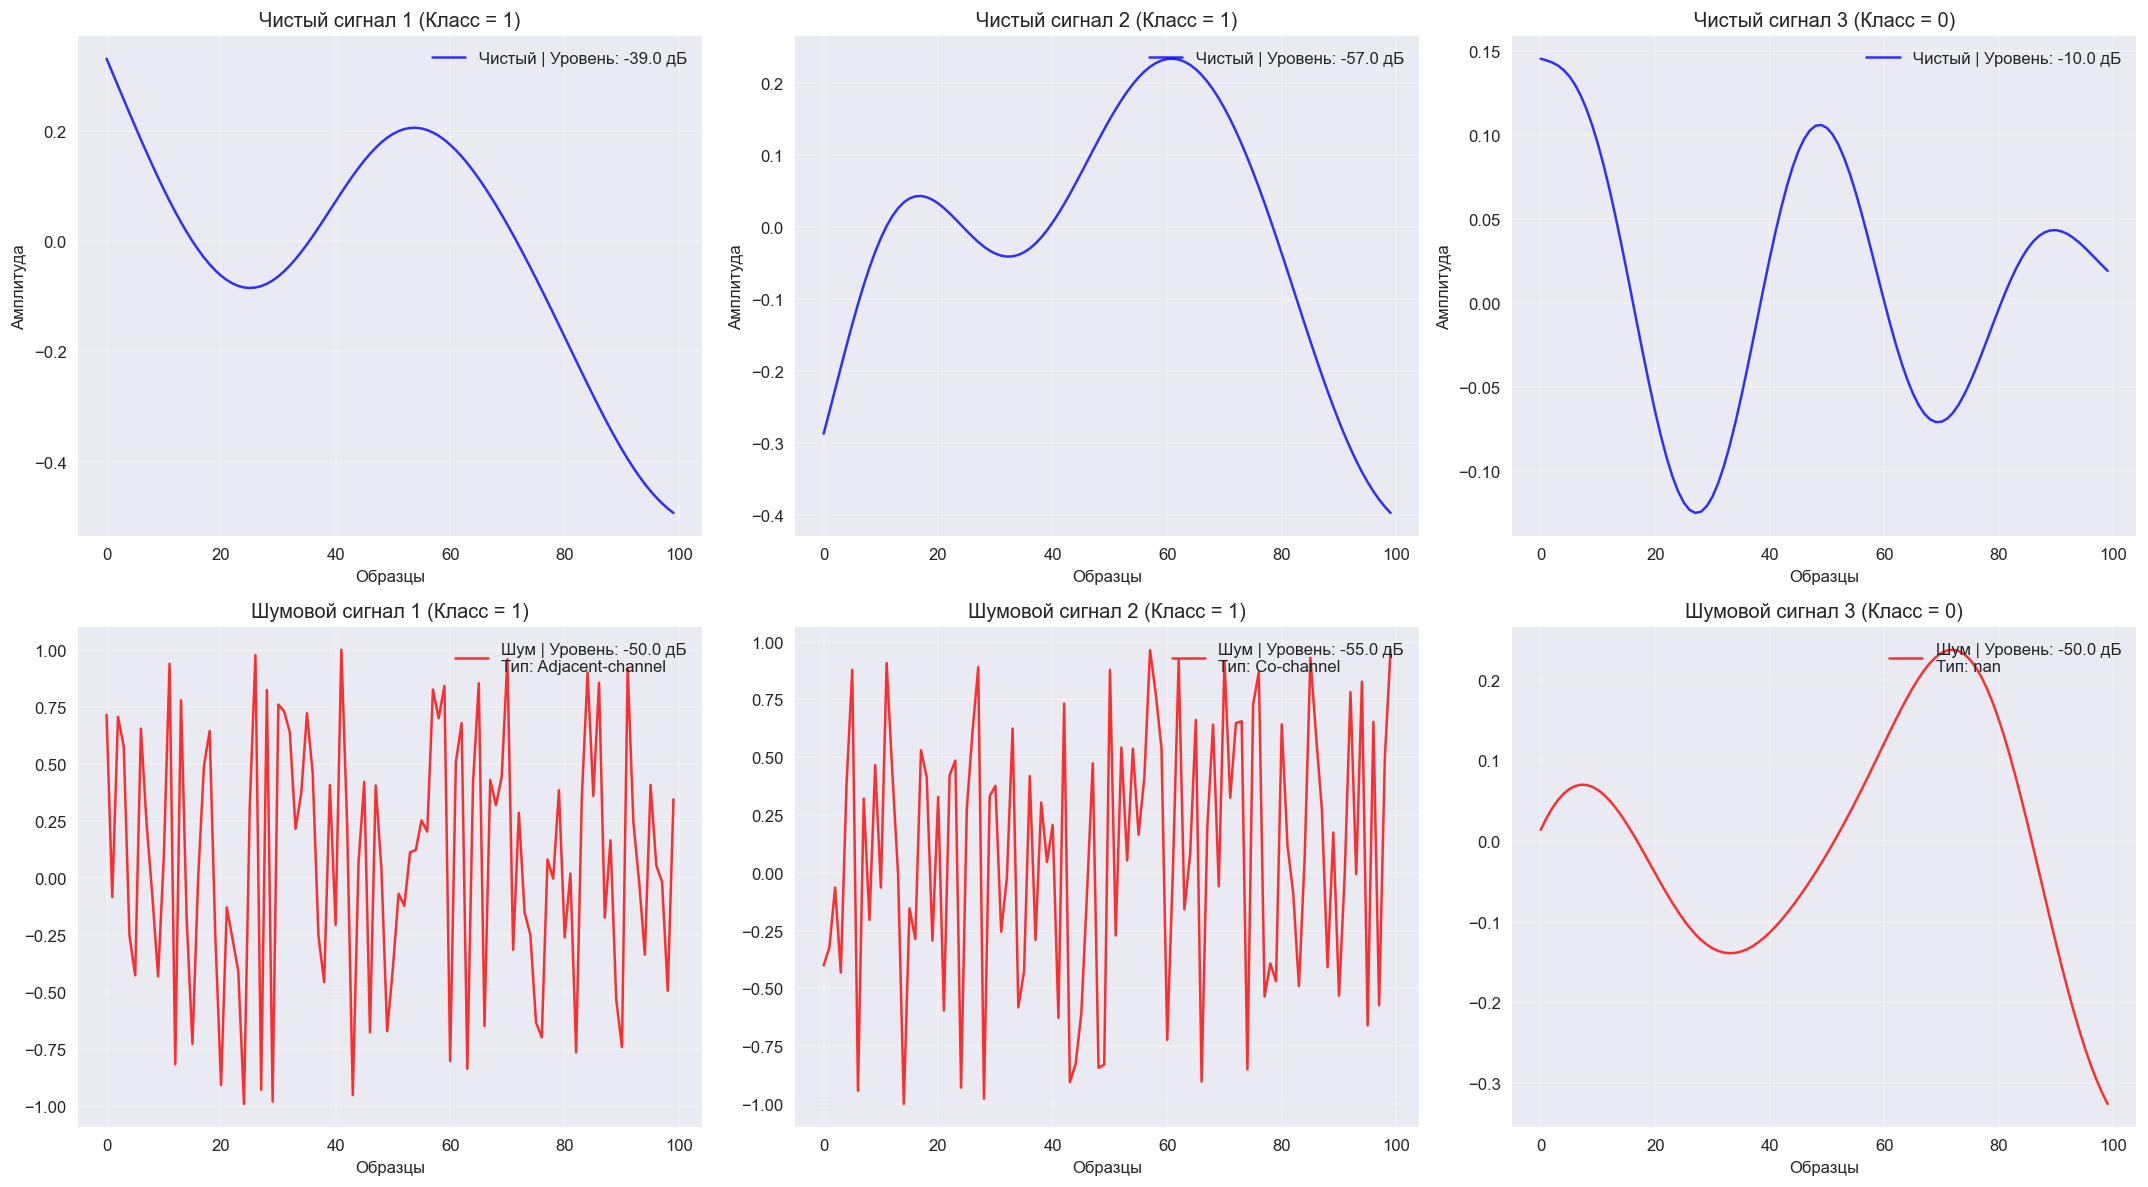

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Загрузка итогового набора данных
try:
    df = pd.read_csv("final_classification_dataset.csv")
except FileNotFoundError:
    raise FileNotFoundError("Файл 'final_classification_dataset.csv' не найден. Проверьте путь.")

# Функция для преобразования сигналов (адаптирована под формат итогового набора данных)
def convert_signal(signal_str):
    if isinstance(signal_str, str):
        try:
            # Удаляет скобки и преобразует в numpy-массив
            cleaned = signal_str.strip('[]').replace('\n', ' ').split()
            return np.array([float(x) for x in cleaned])
        except:
            return np.array([])
    return signal_str

# Применение преобразования к столбцам сигналов
df['clean_signal'] = df['clean_signal'].apply(convert_signal)
df['noise_signal'] = df['noise_signal'].apply(convert_signal)

# Настройки графиков
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

# 1. Создание фигуры с подграфиками для сравнения чистого и шумового сигналов
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 строки, 3 столбца

# Выбор случайных примеров
np.random.seed(42)
sample_indices = np.random.choice(len(df), size=3, replace=False)

# Графики для ЧИСТЫХ сигналов (class = 1)
for i, idx in enumerate(sample_indices):
    row = df.iloc[idx]
    clean_signal = row['clean_signal']
    noise_signal = row['noise_signal']
    class_label = row['class']
    
    # График чистого сигнала (первая строка)
    ax = axes[0, i]
    ax.plot(clean_signal[:200], 
            label=f"Чистый | Уровень: {row['clean_signal_strength']:.1f} дБ",
            color='blue', alpha=0.8, linewidth=1.5)
    ax.set_title(f'Чистый сигнал {i+1} (Класс = {class_label})', fontsize=12)
    ax.set_xlabel('Образцы', fontsize=10)
    ax.set_ylabel('Амплитуда', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

    # График шумового сигнала (вторая строка)
    ax = axes[1, i]
    ax.plot(noise_signal[:200], 
            label=f"Шум | Уровень: {row['noise_signal_strength']:.1f} дБ\nТип: {row['noise_interference_type']}",
            color='red', alpha=0.8, linewidth=1.5)
    ax.set_title(f'Шумовой сигнал {i+1} (Класс = {class_label})', fontsize=12)
    ax.set_xlabel('Образцы', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('sinais_finais_comparados.png', bbox_inches='tight', dpi=150)
plt.show()
